In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from sklearn.datasets import fetch_openml

In [0]:
mnist = fetch_openml('mnist_784', version=1,)
x_train = mnist.data[:60000]
x_test = mnist.data[60000:]
y_train = mnist.target[:60000]
y_test = mnist.target[60000:]

## 共分散行列を計算
今回の場合、28 x 28の画像の共分散行列は各ピクセル単位の共分散行列であると言える。

In [0]:
c = np.cov(x_train, rowvar=0, bias=0)

## 固有ベクトルの計算
- 固有ベクトルを計算する。
- wが固有値、vが固有ベクトル

In [0]:
w, v = LA.eigh(c)

## 使う固有ベクトルを選択する
- 固有値が大きい固有ベクトルがそのデータの分散が大きい方向なので、その観点で選択する。
- 今回は2次元に落とし込むので、大きい方から2つ持ってくる。

In [0]:
m1 = np.argmax(w)
idx = [True] * w.shape[0]
idx[m1] = False
m2 = np.argmax(w[idx])

In [0]:
m1, m2

(783, 782)

## 座標を変換する

$ (x_0', x_1' ,\cdots x_{783}') = (x_0 - E(x_0), x_1 - E(x_1), \cdots x_{783} - E(x_{783}) \cdot (\vec{v_{783}}, \vec{v_{782}})$

In [0]:
mean = np.mean(x_train, axis=0)

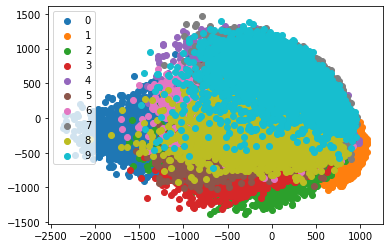

In [0]:
compressed = (x_train - mean).dot(np.hstack([v[:, m1][:, np.newaxis], v[:, m2][:, np.newaxis]]))
for i in range(10):
    idx = (y_train.astype("int") == i)
    plt.scatter(compressed[idx, 0], compressed[idx, 1], label=str(i))
plt.legend()

残しておいたテストデータもやってみる

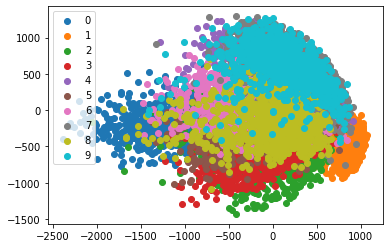

In [0]:
compressed = (x_test - mean).dot(np.hstack([v[:, m1][:, np.newaxis], v[:, m2][:, np.newaxis]]))
for i in range(10):
    idx = (y_test.astype("int") == i)
    plt.scatter(compressed[idx, 0], compressed[idx, 1], label=str(i))
plt.legend()

## 異常検出
- 異常検出もやってみることにする。
- クレジットカード取引情報を使う

In [0]:
!wget https://github.com/aapatel09/handson-unsupervised-learning/raw/master/datasets/credit_card_data/credit_card.csv

--2020-04-24 12:26:50--  https://github.com/aapatel09/handson-unsupervised-learning/raw/master/datasets/credit_card_data/credit_card.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv [following]
--2020-04-24 12:26:51--  https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/plain]
Saving to: ‘credit_card.csv’

credit_card.csv     100%[================

In [0]:
import pandas as pd
df = pd.read_csv("credit_card.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
credit = df.to_numpy()
X = credit[:, 1:30]
Y = credit[:, 30]

In [0]:
X.shape

(284807, 29)

In [0]:
X_train = X[:int(X.shape[0] * 0.95)]
X_test = X[int(X.shape[0] * 0.95):]
Y_train = Y[:int(X.shape[0] * 0.95)].astype("int")
Y_test = Y[int(X.shape[0] * 0.95):].astype("int")

## まずは単純にPCA

In [0]:
c = np.cov(X_train, rowvar=0, bias=0)

In [0]:
w, v = LA.eigh(c)

In [0]:
to_dim = 10 # ここを変えると次元数をいじれる
vs = []
idx = [True] * w.shape[0]
for i in range(to_dim):
    ch = np.argmax(w[idx])
    vs.append(v[ch][:, np.newaxis])
    idx[ch] = False

In [0]:
mean = np.mean(X_train, axis=0)

In [0]:
compressed = (X_train - mean).dot(np.hstack(vs))

## 逆変換
- 固有ベクトル行列は正方行列とは限らないので、pinvを使う。

In [0]:
decompressed = compressed.dot(LA.pinv(np.hstack(vs))) + mean

## 異常の検出
- 戻した結果ともとの値の差分が大きいものがいつもと違う挙動と仮定し、何を使っていいかよくわからなかったので二乗和誤差で数値が大きいものから順にスコアが高いとして扱う

In [0]:
rank = list(reversed(np.argsort(np.sum((X_train - decompressed) ** 2, axis=1), )))

- エラー全数のカウント

In [0]:
error = np.sum((Y_train.astype("int")==1) * 1)
error

481

- ROC曲線の描画

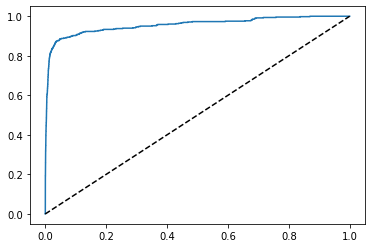

In [0]:
cnt = 0
point = [0, 0]
roc = []
roc.append([0, 0])
for ridx in rank:
    if Y_train[ridx] == 1:
            point[1] = point[1] +1
            cnt = cnt + 1
    else:
        point[0] = point[0] +1
    roc.append([point[0], point[1]])
    if cnt == error:
        roc.append([Y_train.shape[0], point[1]])
        break
roc = np.array(roc)
plt.plot(roc[:, 0] / Y_train.shape, roc[:, 1] / error)
plt.plot([0,1], color='black', linestyle='dashed')